### Let's try to analyse the data in hand.


Libraries

In [ ]:
import numpy as np, pandas as pd 
import os
import zipfile
import re

import pandas as pd

from pathlib import Path


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from textblob import TextBlob
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.graph_objs as go
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline

Helper Functions

In [ ]:
def extract(filepath):
    pattern = r'(\w+)/(\d+)\.txt$'
    category, file_id = re.search(pattern, str(filepath)).groups()
    with open(filepath, 'r', encoding='unicode_escape') as f:
        text = f.read()
        return category, file_id, text
    
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
def remove_stop(text):
    word_tokens = word_tokenize(text)

    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return(" ".join(filtered_sentence))
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def data_clean(news_articles):
#     from nltk.stem.porter import PorterStemmer
    from tqdm import tqdm
#     ps = PorterStemmer()
    clean_articles = []
    for article in tqdm(news_articles):
        # Replace the end lines <\n>
        article = article.replace("\\n",'')

        # Remove all excepth the alphabets
        article = re.sub("[^a-zA-Z'0-9]",' ', article)

        # Lower all the aplhabets
        article = article.lower()

        # Split the article on spaces, returning a list of words
        words = article.split()

       # Remove stopwords
#         clean_article = [ps.stem(word) for word in words]

        # Join clean words
        clean_article = " ".join(words)

        # Append the article
        clean_articles.append(clean_article)
    return(clean_articles)


def get_top_n_words_tfidf(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
def get_top_n_words(corpus, n=None,remove_stopwords=False):
    if(remove_stopwords):
        vec = CountVectorizer(stop_words = 'english').fit(corpus)
    else:
        vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None,remove_stopwords=False):
    if(remove_stopwords):
        vec = CountVectorizer(stop_words = 'english',ngram_range=(2, 2)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
dataset_path = Path('../input/bbc-news-summary/BBC News Summary/')

articles_data = list(map(extract, dataset_path.glob('News Articles/*/*.txt')))
summaries_data = list(map(extract, dataset_path.glob('Summaries/*/*.txt')))

articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'Article'))
summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'Summary'))

df = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))


In [ ]:
## Word length stats before stopwords removal
(pd.Series(data_clean(df['Article'])).apply(lambda x: len(str(x).split()))).describe()

In [ ]:
temp=pd.Series(data_clean(df['Article']))
pd.Series((temp.str.len())).hist()

In [ ]:
df['Category'].value_counts().plot.bar()

**As we can see the dataset does no huge bias wrt to category. Else we might have to**
>* Use Over/Under sampling techniques to balance the dataset.
>* Manipulate class weight if dealing with classification problems.   

In [ ]:

stop_words = set(stopwords.words('english'))
temp=pd.Series(map(remove_stop,temp))
text_data = pd.DataFrame(temp[~temp.isnull()],columns=['Text'])


text_data['Text'] = preprocess(text_data['Text'])

text_data['polarity'] = text_data['Text'].map(lambda text: TextBlob(text).sentiment.polarity)
text_data['review_len'] = text_data['Text'].astype(str).apply(len)
text_data['word_count'] = text_data['Text'].apply(lambda x: len(str(x).split()))
text_data['Category']=df.Category
text_data.polarity.describe()

In [ ]:
text_data['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

This shows most of them are neutral text(bit skewed toward positive polarity). Which make sense because it's a news corpus.

In [ ]:
text_data['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

In [ ]:
text_data['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')
print(text_data['word_count'].describe(percentiles=[.25, .5, .75,0.85]))

This gives us the Idea that a sentence with word count of 331(350 on more conservative side) can be selected for our prediction.

In [ ]:
trace1 = go.Scatter(
    x=text_data['Category'], y=text_data['polarity'], mode='markers', name='points',
    marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4)
)
trace2 = go.Histogram2dContour(
    x=text_data['Category'], y=text_data['polarity'], name='density', ncontours=20,
    colorscale='Hot', reversescale=True, showscale=False
)
trace3 = go.Histogram(
    x=text_data['Category'], name='Category density',
    marker=dict(color='rgb(102,0,0)'),
    yaxis='y2'
)
trace4 = go.Histogram(
    y=text_data['polarity'], name='Sentiment Polarity density', marker=dict(color='rgb(102,0,0)'),
    xaxis='x2'
)
data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    showlegend=False,
    autosize=False,
    width=600,
    height=550,
    xaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    margin=dict(
        t=50
    ),
    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='2dhistogram-2d-density-plot-subplots')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
common_words = get_top_n_words(df['Article'], 20,False)
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

common_words = get_top_n_words(df['Article'], 20,True)
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
#Plot uni-gram
df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

df2.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [ ]:
common_words = get_top_n_bigram(df['Article'], 20,False)
df3 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

common_words = get_top_n_bigram(df['Article'], 20,True)
df4 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
#Plot Bi-gram
df3.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

df4.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [ ]:
reindexed_data = df['Article']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 7
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
top_n_words_lsa = get_top_n_words_tfidf(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

In [ ]:
# top_5_words = get_top_n_words(5, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_n_words_lsa[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

## Visualizing text from an Eye of Transformer

Now let's take a look at how a basic Bert encodes the knowledge we provide via text. Let's make some visualizations of the embeddings, using a dimensional reduction algorithm called [t-SNE](https://lvdmaaten.github.io/tsne/). Here's a sketch:
1. For BERT-large, each word is represented as a vector in a 1024-dimensional space;
2. Using a good old PCA, we reduce this to a 50-dimensional space, hopefully without losing too much information;
3. Using PCA to further reduce from 50 to 2 dimensions would probably kill a lot of useful information, so we want a more refined method. What t-SNE does, roughly, is create vectors in a 2-dimensional space, such that if two vectors have small distance in the 50-dimensional space, they also have small distance in the 2-dimensional space. We get a 2-dimensional plot, which offers a little insight into how BERT embeddings for various words are distributed.

Let's try to check the hypothesis lot of people noticed that you can concatenate different layers of BERT, not necessarily the last ones. 
For ex my office project, what worked best was concatenating layers -5, -6.

So it's safe to say that we can do a bit of a experiment on how the layers percive knowledge to take the decision. So in the graphs below, I took the sample of 300 data points following same distribution as orignal, and I'm plotting the result of t-SNE for layer -1, and separately for layer -5. Hopefully staring long enough at plots like these can reveal something about the different ways in which BERT layers encode information.

In [ ]:
#Sample no. of rows
nrows=300

In [ ]:
df_sample=df.sample(300)
text=data_clean(df_sample.Article)

In [ ]:
#downloading weights and cofiguration file for bert
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip
with zipfile.ZipFile("uncased_L-24_H-1024_A-16.zip","r") as zip_ref:
    zip_ref.extractall()
!rm "uncased_L-24_H-1024_A-16.zip"
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/extract_features.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

import modeling
import extract_features
import tokenization
import tensorflow as tf

In [ ]:
df_sample.head(5)

Taking sample set of 300 (following same distribution of orignal) sample set.

In [ ]:
text = pd.Series(text)
text.to_csv("input300.txt", index = False, header = False)

In [ ]:
def get_encoding():
    os.system("python3 extract_features.py \
      --input_file=input300.txt \
      --output_file=output300.jsonl \
      --vocab_file=uncased_L-24_H-1024_A-16/vocab.txt \
      --bert_config_file=uncased_L-24_H-1024_A-16/bert_config.json \
      --init_checkpoint=uncased_L-24_H-1024_A-16/bert_model.ckpt \
      --layers=-1,-5 \
      --max_seq_length=256 \
      --batch_size=8")

    bert_output = pd.read_json("output300.jsonl", lines = True)
    return(bert_output)

# os.system("rm output300.jsonl")
# os.system("rm input300.txt")

In [ ]:
bert_output = get_encoding()
df_sample.reset_index(inplace=True)

In [ ]:
#Create a 2-d embedding representation from a base bert's embedding s 
from tqdm import tqdm
emb_2d = {}
for row in tqdm(range(nrows)):    
    # Get the BERT embeddings for the current line in the data file
    features = pd.DataFrame(bert_output.loc[row,"features"]) 

    span = range(2,len(features)-2)
    emb1, emb5 = {}, {}
    count_chars = 0

    # Make a list with the text of each token, to be used in the plots
    texts = []

    for j in span:
        token = features.loc[j,'token']
        texts.append("@"+df_sample.loc[row,"Category"] +token)
        emb1[j] = np.array(features.loc[j,'layers'][0]['values'])
        emb5[j] = np.array(features.loc[j,'layers'][1]['values'])

    X1 = np.array(list(emb1.values()))
    X5 = np.array(list(emb5.values()))
    if row == 0: print("Shape of embedding matrix: ", X1.shape)

    # Use PCA to reduce dimensions to a number that's manageable for t-SNE
    pca = PCA(n_components = 50, random_state = 7)
    X1 = pca.fit_transform(X1)
    X5 = pca.fit_transform(X5)
    if row == 0: print("Shape after PCA: ", X1.shape)

    # Reduce dimensionality to 2 with t-SNE.
    # Perplexity is roughly the number of close neighbors you expect a point to have.
    tsne = TSNE(n_components = 2, perplexity = 10, random_state = 6, 
                learning_rate = 1000, n_iter = 1500)
    X1 = tsne.fit_transform(X1)
    X5 = tsne.fit_transform(X5)
    if row == 0: print("Shape after t-SNE: ", X1.shape)
    # Recording the position of the tokens, to be used in the plot
    position = np.array(list(span)) 
    position = position.reshape(-1,1)

    X = pd.DataFrame(np.concatenate([X1, X5, position, np.array(texts).reshape(-1,1)], axis = 1), 
                     columns = ["x1", "y1", "x5", "y5", "position", "texts"])
    X = X.astype({"x1": float, "y1": float, "x5": float, "y5": float, "position": float, "texts": object})

    # Remove a few outliers based on zscore
    X = X[(np.abs(stats.zscore(X[["x1", "y1", "x5", "y5"]])) < 3).all(axis=1)]
    emb_2d[row] = X


Finally, plot the 2-dimensional representations output by t-SNE. Classes of the news added to the text to retrive later for class labling.

In [ ]:
import pickle
a_file = open("embedding _2D.pkl", "wb")
pickle.dump(emb_2d, a_file)
a_file.close()

In [ ]:
f = open("embedding _2D.pkl","rb")
emb_2d=pickle.load(f)

Let's create a mapping wrt the Category for each Aticle

In [ ]:
for row in range(10):
    X = emb_2d[row]
    
    # Plot for layer -1
    plt.figure(figsize = (30,25))
    p1 = sns.scatterplot(x = X["x1"], y = X["y1"], hue = X["position"], palette = "coolwarm")
    p1.set_title("development-"+str(row+1)+", layer -1")
    
    # Label each datapoint with the word it corresponds to
    for line in X.index:
        text = X.loc[line,"texts"]
        if "@politics" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@politics"):], horizontalalignment='left', 
                    size='small', color='blue')
        elif "@tech" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@tech"):], horizontalalignment='left', 
                    size='small', color='green')
        elif "@sport" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@sport"):], horizontalalignment='left', 
                    size='small', color='brown')    
        elif "@entertainment" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@entertainment"):], horizontalalignment='left', 
                    size='small', color='red')
        elif "@business" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@business"):], horizontalalignment='left', 
                    size='small', color='black') 
        else:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], "", horizontalalignment='left', 
                    size='small', color='black')
    
    # Plot for layer -5
    plt.figure(figsize = (20,15))
    p1 = sns.scatterplot(x = X["x5"], y = X["y5"], hue = X["position"], palette = "coolwarm")
    p1.set_title("development-"+str(row+1)+", layer -5")
    
    for line in X.index:
        text = X.loc[line,"texts"]
        if "@politics" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@politics"):], horizontalalignment='left', 
                    size='small', color='blue')
        elif "@tech" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@tech"):], horizontalalignment='left', 
                    size='small', color='green')
        elif "@sport" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@sport"):], horizontalalignment='left', 
                    size='small', color='brown')    
        elif "@entertainment" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@entertainment"):], horizontalalignment='left', 
                    size='small', color='red')
        elif "@business" in text:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], text[len("@business"):], horizontalalignment='left', 
                    size='small', color='black') 
        else:
            p1.text(X.loc[line,"x1"]+0.2, X.loc[line,"y1"], "", horizontalalignment='left', 
                    size='small', color='black')

There's some useful information in these plots. Notice two reasons why points are close:
1. They represent the same word, or similar words, independently of context, such as "gift" and "contribution" for "donation" or "arrested" and "detained".
2. It's interesting to see that along with context it is understanding the word used in different tenses and mapping them together,
    example, 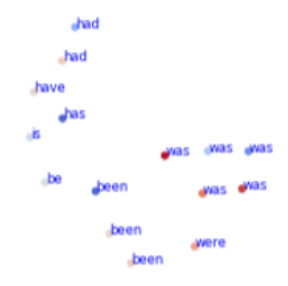
    
    In this example "were" and "was" is very close so is the word "is" also "had","have" and "has".
3. They represent tokens which have close positions in the sentence, such as "were" and "been" in image.
4. It also groups the words by the genere or field in which they are generally used used.
    for example, generally "artist","music","instrument",a "write" or a "play" generally maps artistic field
   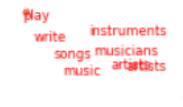 , we can se they are close in 2d- representation

In some cases, you can see directly from these plots that BERT has learned some information that's very useful for co-reference resolution. For example, "spokesmen" and "spokesperson" are very close together.